In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import pchip_interpolate

In [2]:
from toy_tools import *

In [4]:
def deconv(m, r, npoints):
    m_fft = np.fft.fft(m, n=npoints)
    r_fft = np.fft.fft(r, n=npoints)
    s_fft = m_fft / r_fft
    #s_fft[npoints//2-10:npoints//2+10] = 0
    return np.fft.ifft(m_fft / r_fft)

In [143]:
def run(pos=8700, interval=5, average=False, fresample=resample):
    q = 30_600
    delay = 15
    thres = 6_000
    roi = 5*delay
    npoints = 10_000
    npoints_resample = npoints // interval

    unit_fr = load_fr_ctr('response_44_v2a_100ns.npy')

    aux_t = npoints - len(unit_fr) - pos
    x0 = -80 + aux_t
    x1 = 80 + aux_t
    
    q0 = q*np.ones(1)
    r = 20
    sigma = 2
    q1 = q_gaus(q=q, r=21, sigma=sigma)
    
    fr0 = fr_record(q0, pos, unit_fr)
    fr1 = fr_record(q1, pos, unit_fr)
    ts_q0 = [aux_t]
    ts_q1 = np.arange(0+aux_t, len(q1)+aux_t, 1, dtype=np.int_)

    unit_fr_ts_resample, unit_fr_resample = fresample(unit_fr, interval, average, True)
    print(unit_fr_ts_resample.shape, unit_fr_resample.shape)
    ts0, r0_smooth = fresample(fr0, interval, average)
    ts1, r1_smooth = fresample(fr1, interval, average)

    q0_ifft = deconv(r0_smooth, unit_fr_resample, len(r0_smooth))
    q1_ifft = deconv(r1_smooth, unit_fr_resample, len(r1_smooth))

    fig, ax = plt.subplots(1, 2, figsize=(5*2, 3))
    # ax[0].plot(ts_q1, q1)
    ax[0].plot(q*unit_fr, label='q0 * unit_fr')
    ax[0].plot(unit_fr_ts_resample, q*unit_fr_resample, label='q0 * unit_fr (resampled)')
    ax[0].plot(fr0, label='truth')
    ax[0].plot(ts0, r0_smooth, label='resampled')
    ax[1].plot(q*unit_fr, label='q0 * unit_fr')
    ax[1].plot(unit_fr_ts_resample, q*unit_fr_resample, label='q1 * unit_fr (resampled)')
    ax[1].plot(fr1, label='truth')
    ax[1].plot(ts1, r1_smooth, label='resampled')
    ax[0].set_xlim(aux_t + 1100, aux_t + 1300)
    ax[1].set_xlim(aux_t + 1100, aux_t + 1300)
    ax[0].legend()
    ax[1].legend()

    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(5*2, 3))
    ax0.bar(x=ts_q0, height=q0, width=1, label='qDelta')
    ax0.plot(ts0, q0_ifft, linestyle='dotted', label='deconv.', c='orange')
    ax1.bar(x=ts_q0, height=q0, width=1, label='qDelta')
    ax1.plot(ts0, q0_ifft, linestyle='dotted', label='deconv.', c='orange')
    ax0.legend()
    ax1.legend()
    ax1.set_xlim(x0, x1)
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(5*2, 3))

    ax0.plot(ts_q1, q1, linestyle='--', label='qGaus')
    ax0.plot(ts1, q1_ifft, linestyle='dotted', label='deconv.')
    ax1.plot(ts_q1, q1, linestyle='--', label='qGaus')
    ax1.plot(ts1, q1_ifft, linestyle='dotted', label='deconv.')
    ax0.legend()
    ax1.legend()
    ax1.set_xlim(x0, x1)

    '''
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(5*2, 3))

    ax0.plot(ts_q1, q1, linestyle='--', label='qGaus')
    ax0.bar(x=ts1, height=q1_ifft, width=interval, label='deconv.', align='edge', hatch='/', fill=False, edgecolor='r')
    ax1.plot(ts_q1, q1, linestyle='--', label='qGaus')
    ax1.bar(x=ts1, height=q1_ifft, width=interval, label='deconv.', align='edge', hatch='/', fill=False, edgecolor='r')
    ax0.legend()
    ax1.legend()
    ax1.set_xlim(-80+aux_t, 80+aux_t)
'''
    print(np.sum(q1))
    print(np.sum(q1_ifft))

    return q0_ifft, q1_ifft

## Resample by averaging every k points
For example, first 5 points are summed and divided by 5. The time of first point is picked. Interval between ticks becomes 5 times larger.

Length of new waveform is truncated as npoints // interval * interval

In [45]:
'''
pick the average, also on fr template; bin size == interval
'''

def resample(wf, interval, average=True, isfr=False):
    npoints = wf.shape[0]
    nelements = npoints // interval
    wf_new = wf[:nelements*interval]
    wf_new = wf_new.reshape(nelements, interval)
    wf_new = np.sum(wf_new, axis=1)
    if average:
        wf_new = wf_new / interval
    output = np.arange(0, nelements*interval, interval, dtype=np.int_), wf_new
    return output

shape of center region (5, 5, 2000)
integration of first 700 ticks 0.0010430221411030683
drop first 700 ticks and renormalize
30599.999233925155
(30599.999233925166+6.15942594796566e-27j)


(array([-6.09369025e-12+2.16138632e-12j,  3.06000000e+04+6.15775858e-13j,
        -4.32485271e-12-2.26243936e-12j, ...,
         1.13285123e-13-1.66258436e-12j, -1.97551291e-12+5.29317768e-12j,
         4.41599730e-12-5.58350866e-12j]),
 array([ 1.10012479e-12-7.44912705e-13j,  6.63238864e-03+6.92405834e-13j,
         9.09584235e-02-1.38900548e-12j, ...,
         1.71306070e-12-6.87920503e-13j, -4.80887000e-12+1.38190138e-12j,
         4.33022050e-12+6.97951946e-13j]))

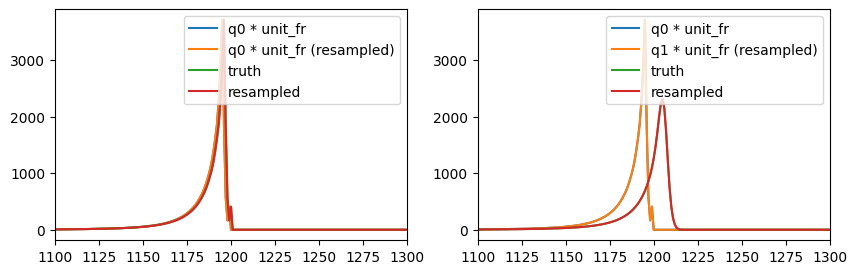

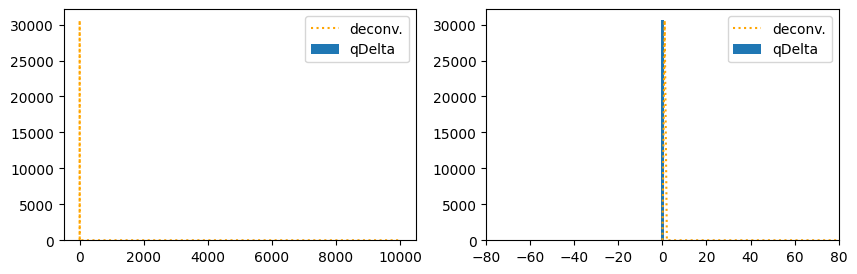

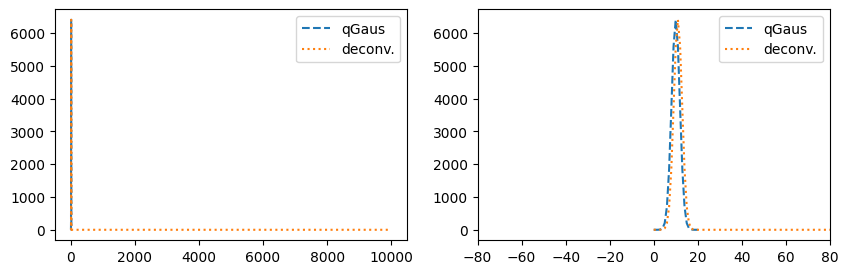

In [132]:
# plt.close('all')
run(8700, 1)

shape of center region (5, 5, 2000)
integration of first 700 ticks 0.0010430221411030683
drop first 700 ticks and renormalize
30599.999233925155
(30599.99923392517+5.048709793414476e-28j)


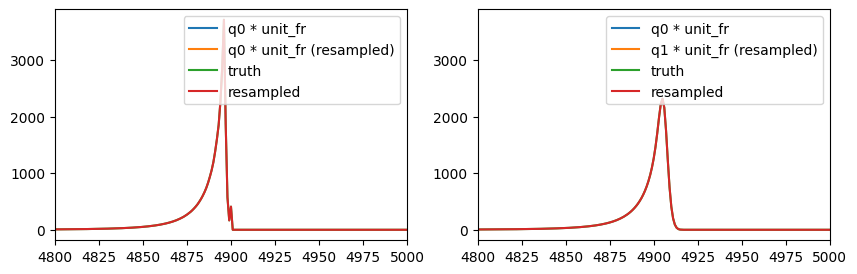

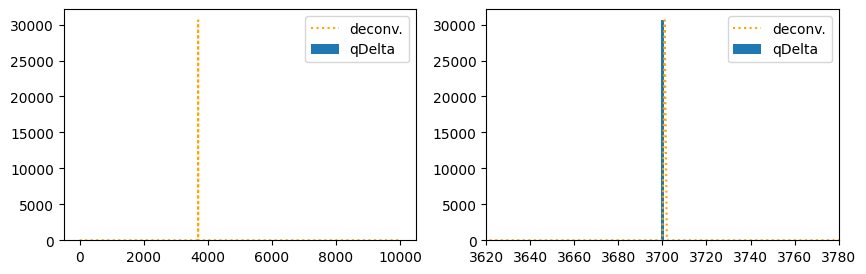

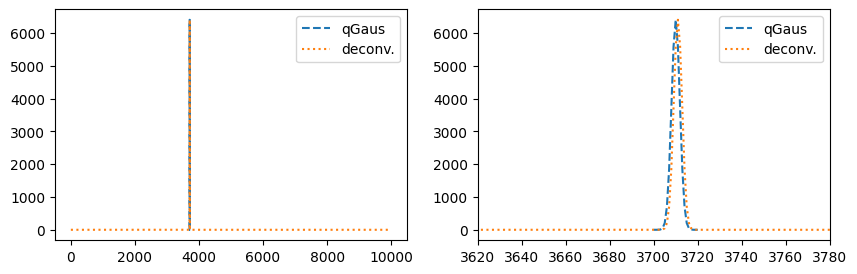

In [133]:
_, q1_ifft = run(5000, 1)

shape of center region (5, 5, 2000)
integration of first 700 ticks 0.0010430221411030683
drop first 700 ticks and renormalize
(650,) (650,)
30599.999233925155
(30599.99923392516+1.6155871338926322e-27j)


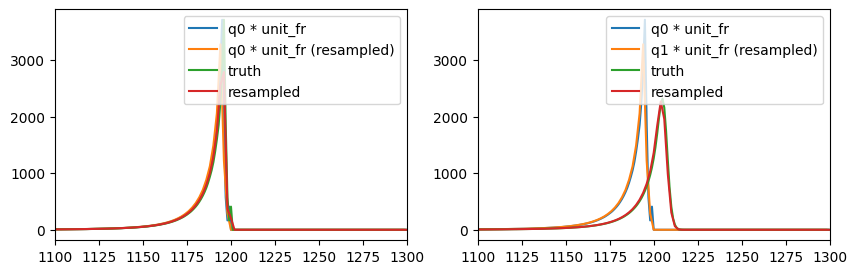

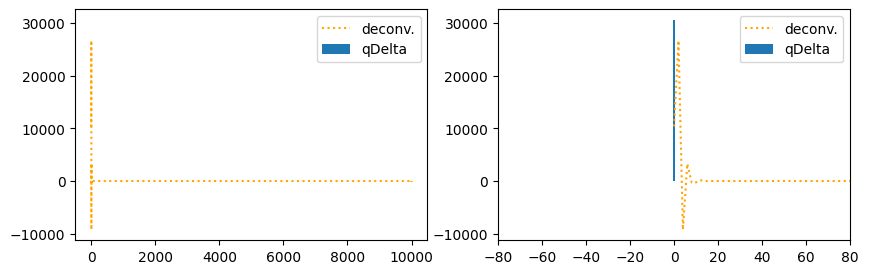

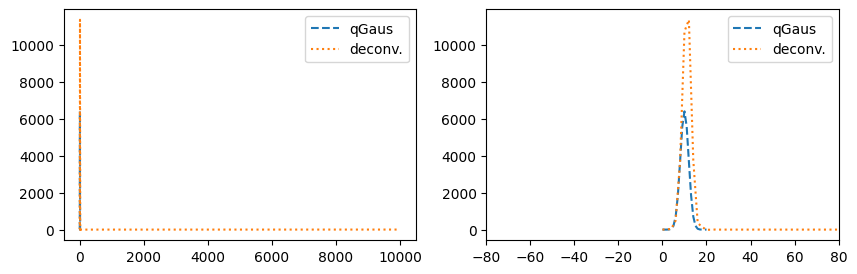

In [144]:
_, q1_ifft = run(8700, 2, True, resample)

## Approximate the waveform by average of every k points
For example, first k points are summed and divided by k. The time of first point is picked. Interval between ticks are the same as old ones.

Length of new waveform is truncated as npoints // interval * interval

In [146]:
'''
pick the average; do nothing to fr; binning same as fr
'''

def resample2(wf, interval, average, isfr=False):

    npoints = wf.shape[0]
    nelements = npoints // interval

    if interval > 50:
        raise NotImplementedError('interval must be < 50')

    if isfr:
        return np.arange(0, nelements * interval, 1, dtype=np.int_), wf[:npoints * interval]
    
    wf_new = wf[:nelements*interval]
    wf_new = wf_new.reshape(nelements, interval)
    print(wf_new.shape)
    wf_new = np.sum(wf_new, axis=1)
    wf_new = wf_new / interval
    wf_resample = np.zeros(nelements * interval)
    for i in range(nelements):
        wf_resample[i*interval:(i+1)*interval] = np.float_(wf_new[i])
    output = np.arange(0, nelements*interval, 1, dtype=np.int_), wf_resample
    print(wf_resample)
    return output

shape of center region (5, 5, 2000)
integration of first 700 ticks 0.0010430221411030683
drop first 700 ticks and renormalize
(1300,) (1300,)
(10000, 1)
[0.         0.08502314 0.08509782 ... 0.         0.         0.        ]
(10000, 1)
[0.00000000e+00 1.84283179e-08 2.71175584e-07 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
30599.999233925155
(30599.999233925166+6.15942594796566e-27j)


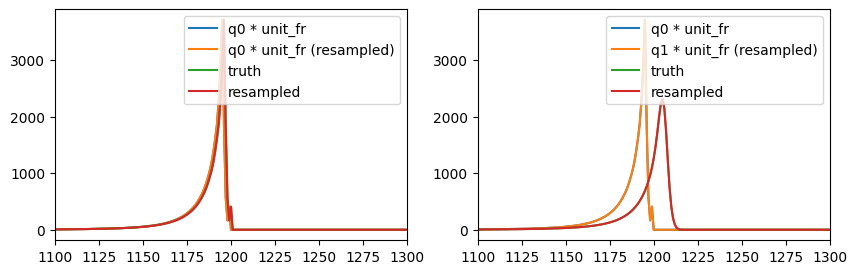

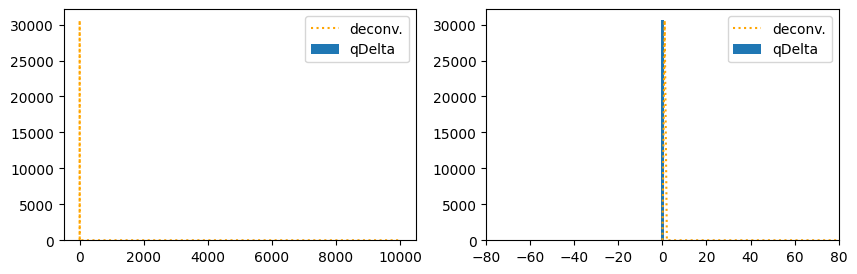

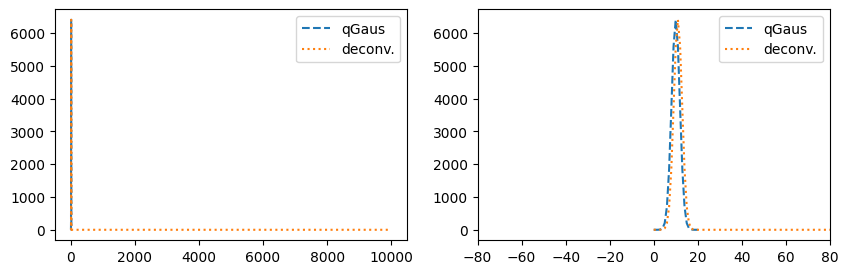

In [156]:
_, q1_ifft = run(8700, 1, True, resample2)

shape of center region (5, 5, 2000)
integration of first 700 ticks 0.0010430221411030683
drop first 700 ticks and renormalize
(1300,) (1300,)
(5000, 2)
[0.04251157 0.04251157 0.08513516 ... 0.         0.         0.        ]
(5000, 2)
[9.21415895e-09 9.21415895e-09 1.58681995e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
30599.999233925155
(30599.999233925166+7.270142102516845e-27j)


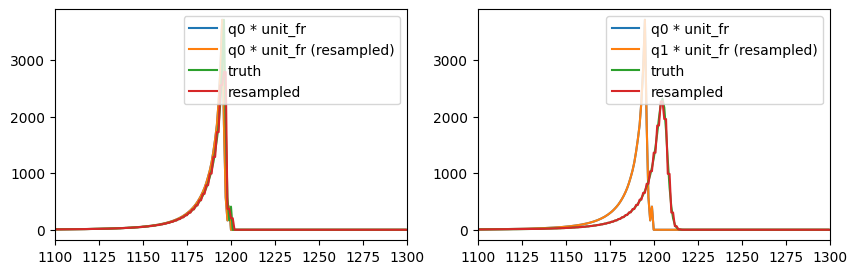

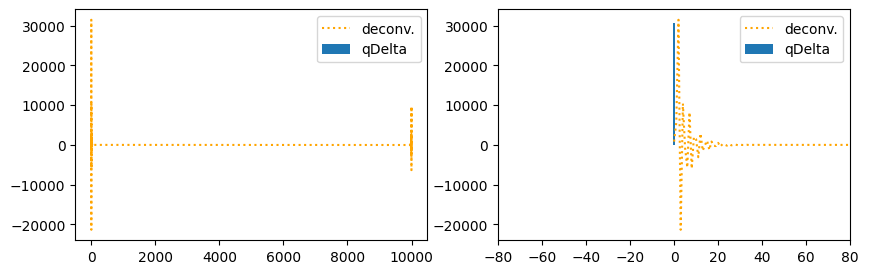

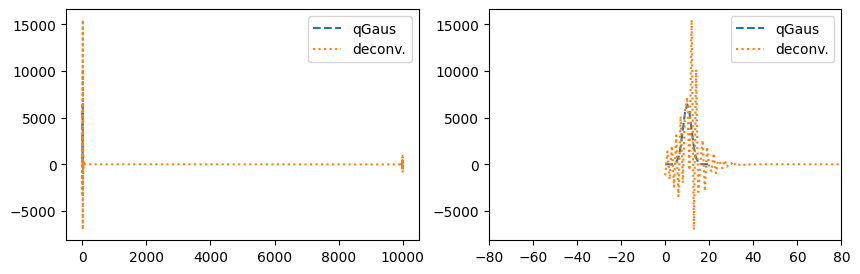

In [147]:
_, q1_ifft = run(8700, 2, True, resample2)

## Use the truth and field response without doing anything

In [155]:
'''
Do nothing.
'''
def resample3(wf, interval, average, isfr=False):
    return np.arange(0, len(wf), 1, dtype=np.int_), wf

shape of center region (5, 5, 2000)
integration of first 700 ticks 0.0010430221411030683
drop first 700 ticks and renormalize
(1300,) (1300,)
30599.999233925155
(30599.999233925166+6.15942594796566e-27j)


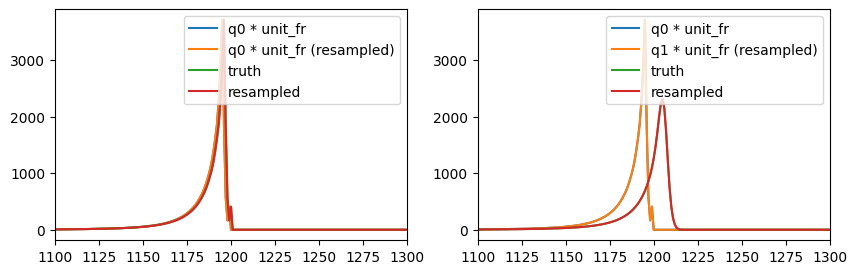

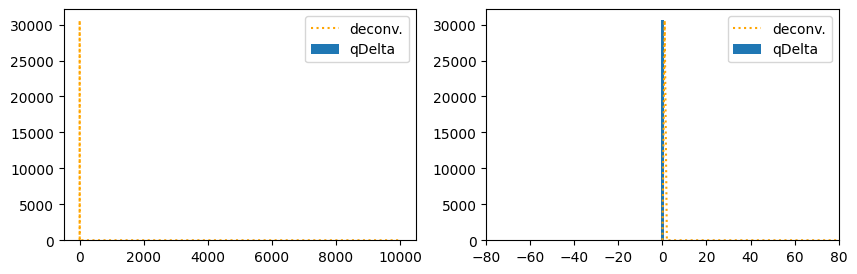

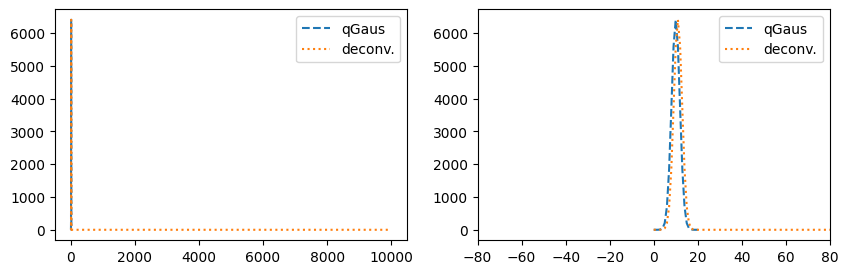

In [157]:
_, q1_ifft = run(8700, 5, True, resample3)

## Approximate the waveform by picking the first point of every k points
picking the first point of every k points The time of first point is picked. Interval between ticks are the same as old ones.

Length of new waveform is truncated as npoints // interval * interval

In [150]:
'''
pick the first; do nothing to fr; binning same as fr
'''
def resample4(wf, interval, average, isfr=False):
    npoints = wf.shape[0]
    nelements = npoints // interval

    if interval > 50:
        raise NotImplementedError('interval must be < 50')
    if isfr:
        return np.arange(0, nelements * interval, 1, dtype=np.int_), wf[:npoints * interval]

    wf_new = wf[:nelements*interval]
    wf_new = wf_new.reshape(nelements, interval)
    wf_new = wf_new[:,0]
    wf_resample = np.zeros(nelements * interval)
    for i in range(nelements):
        wf_resample[i*interval:(i+1)*interval] = np.float_(wf_new[i])
    output = np.arange(0, len(wf), 1, dtype=np.int_), wf_resample
    return output

shape of center region (5, 5, 2000)
integration of first 700 ticks 0.0010430221411030683
drop first 700 ticks and renormalize
(1300,) (1300,)
30599.999233925155
(30599.999233925166+6.15942594796566e-27j)


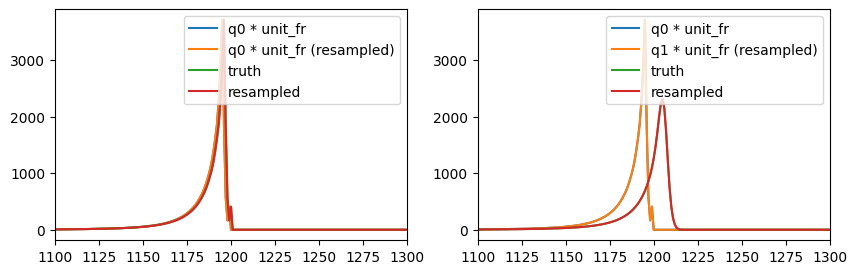

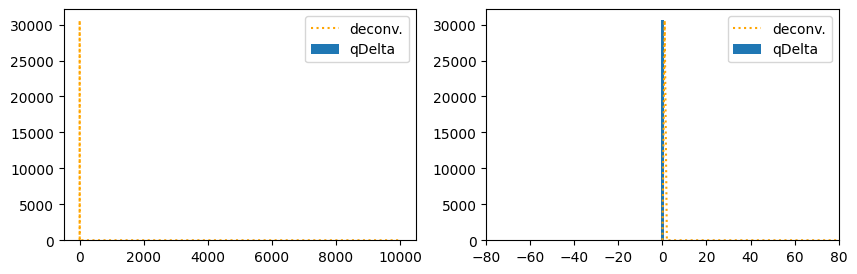

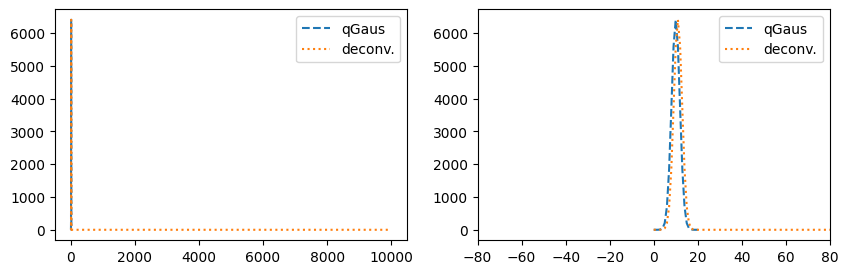

In [158]:
_, q1_ifft = run(8700, 1, True, resample4)

shape of center region (5, 5, 2000)
integration of first 700 ticks 0.0010430221411030683
drop first 700 ticks and renormalize
(1300,) (1300,)
30599.999233925155
(30772.28128455691+1.1107161545511846e-26j)


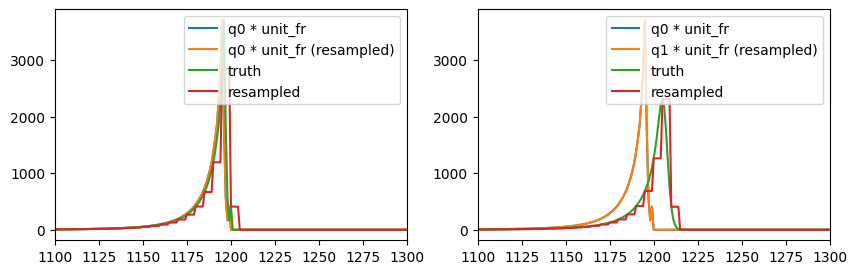

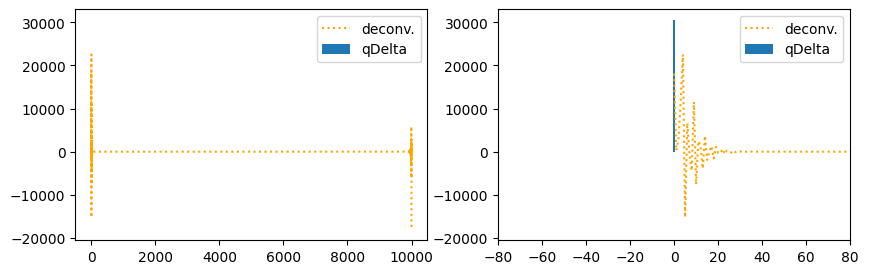

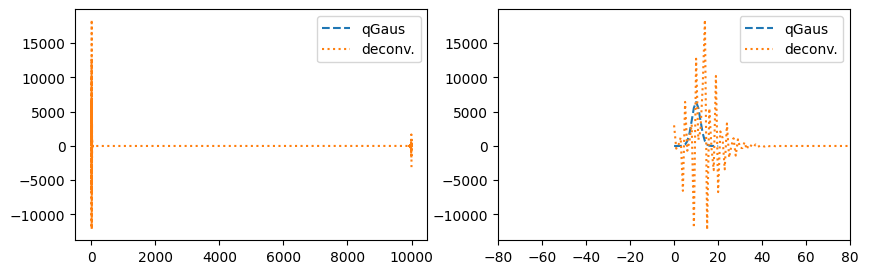

In [151]:
_, q1_ifft = run(8700, 5, True, resample4)

## Resample by picking the first point of every k points
The time of first point is picked. Interval between ticks becomes k times larger.

Length of new waveform is truncated as npoints // interval * interval

In [154]:
'''
pick the first; to wf and fr; bin size same as interval
'''
def resample5(wf, interval, average, isfr=False):
    npoints = wf.shape[0]
    nelements = npoints // interval
    wf_new = wf[:nelements*interval]
    wf_new = wf_new.reshape(nelements, interval)
    wf_new = wf_new[:,0]
    output = np.arange(0, nelements*interval, interval, dtype=np.int_), wf_new
    return output

shape of center region (5, 5, 2000)
integration of first 700 ticks 0.0010430221411030683
drop first 700 ticks and renormalize
(1300,) (1300,)
30599.999233925155
(30599.99923392517-8.077935669463161e-28j)


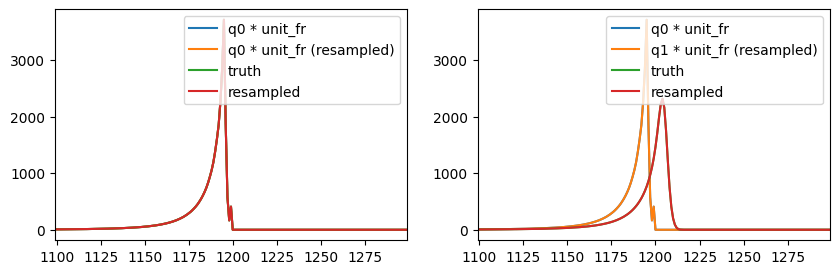

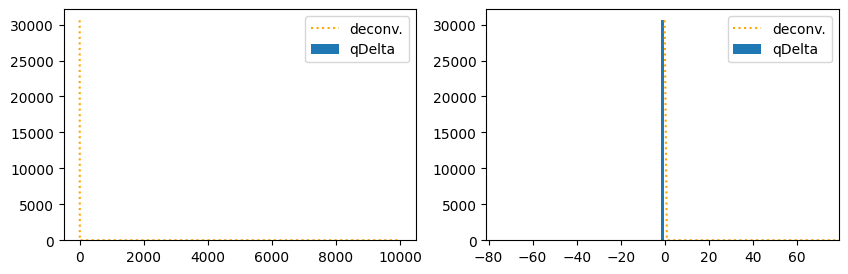

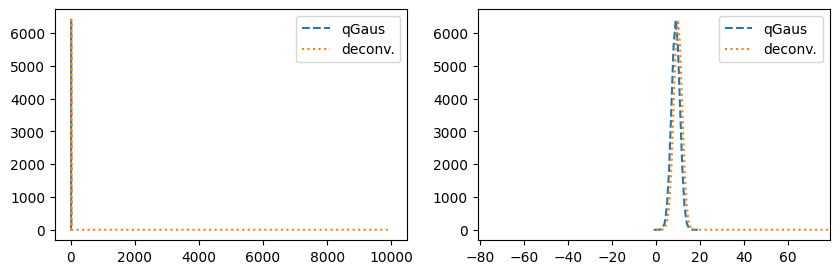

In [180]:
_, q1_ifft = run(8701, 1, True, resample5)

shape of center region (5, 5, 2000)
integration of first 700 ticks 0.0010430221411030683
drop first 700 ticks and renormalize
(650,) (650,)
30599.999233925155
(31725.148911990396-1.5247103576111716e-26j)


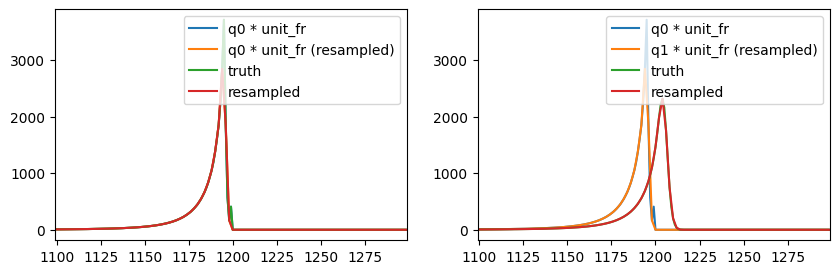

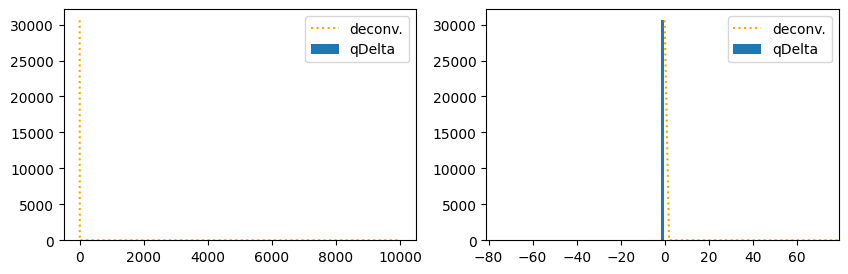

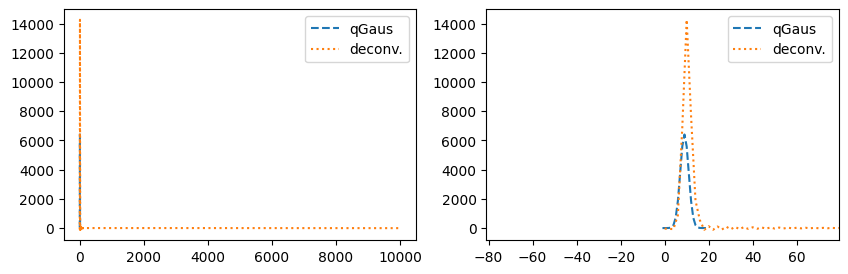

In [183]:
_, q1_ifft = run(8701, 2, True, resample5)

shape of center region (5, 5, 2000)
integration of first 700 ticks 0.0010430221411030683
drop first 700 ticks and renormalize
(433,) (433,)
30599.999233925155
(32375.172800217533-4.0389678347315804e-28j)


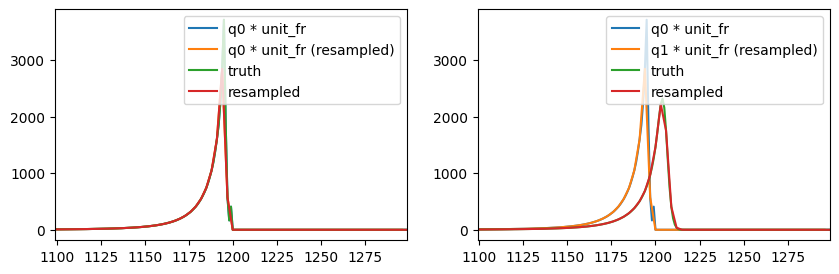

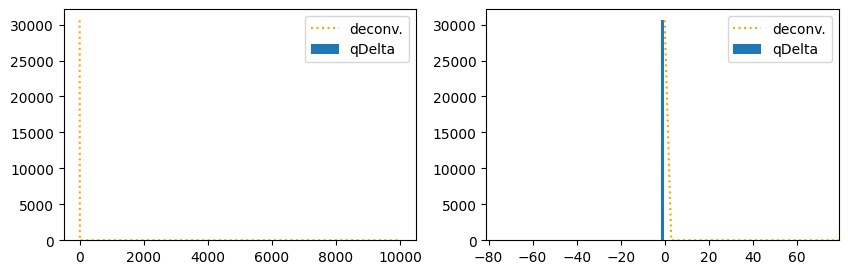

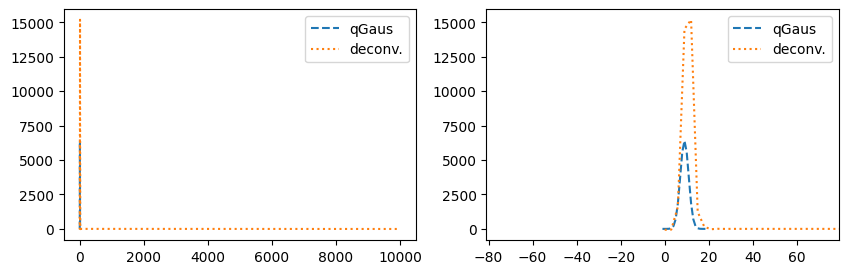

In [192]:
_, q1_ifft = run(8701, 3, True, resample5)

shape of center region (5, 5, 2000)
integration of first 700 ticks 0.0010430221411030683
drop first 700 ticks and renormalize
(325,) (325,)
30599.999233925155
(31912.36525288053+1.3126645462877636e-27j)


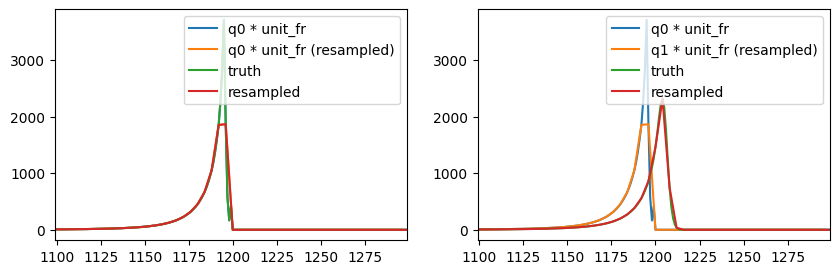

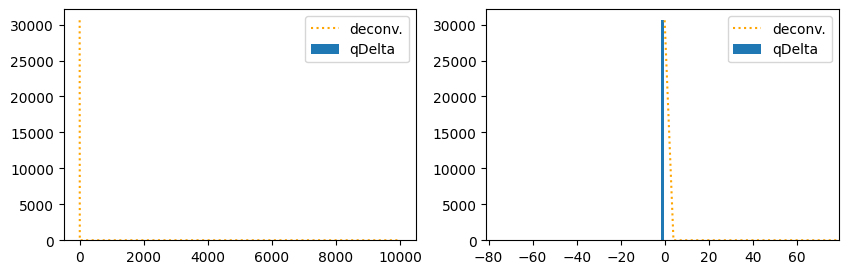

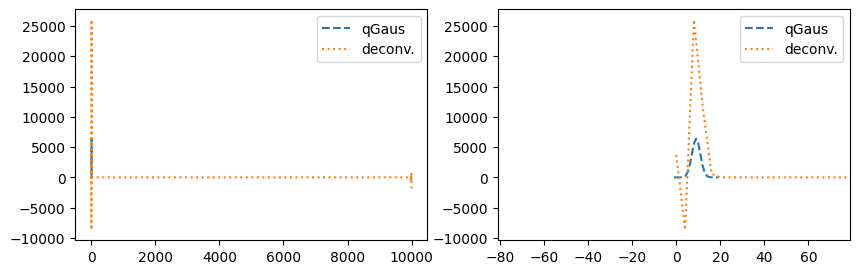

In [193]:
_, q1_ifft = run(8701, 4, True, resample5)

shape of center region (5, 5, 2000)
integration of first 700 ticks 0.0010430221411030683
drop first 700 ticks and renormalize
(260,) (260,)
30599.999233925155
(25548.465167003294+0j)


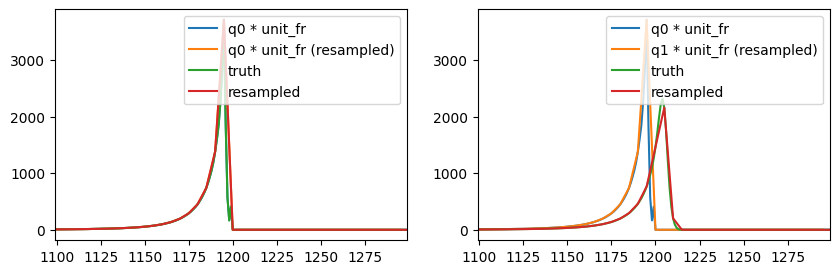

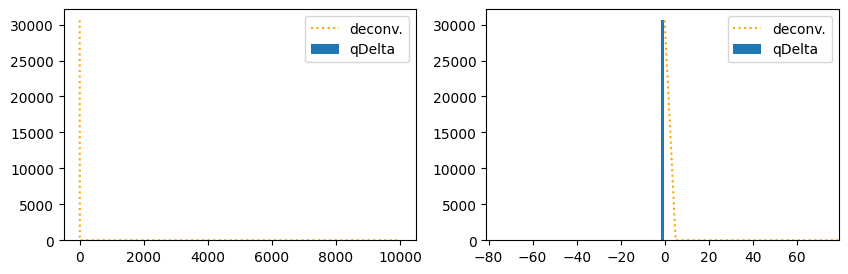

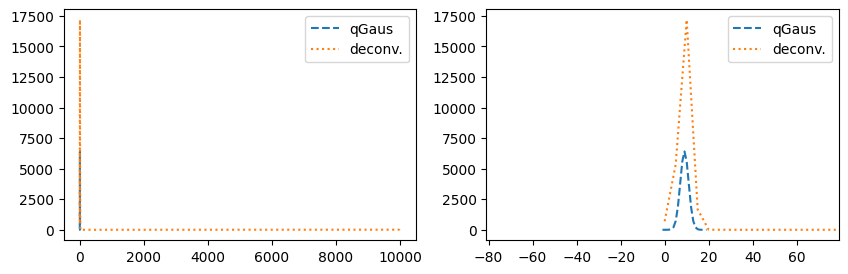

In [194]:
_, q1_ifft = run(8701, 5, True, resample5)